# 1. Подготовка данных

Загрузим необходимые библиотеки и функции.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
import warnings

Прочтем данные.

In [2]:
autos = pd.read_csv('/datasets/autos.csv')
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Проверим на дубликаты.

In [4]:
autos.duplicated().sum()

4

Избавимся от них.  
  
Следующие признаки никак не влияют на наш целевой признак - цену машины:  
DateCrawled - дата скачивания анкеты из базы  
RegistrationMonth - месяц регистрации автомобиля  
DateCreated — дата создания анкеты  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
Эти столбцы можно без сожаления удалить.
В принципе, месяц изготовления тоже лишний.   
Заодно приведем названия столбцов в подобающий вид.

In [5]:
autos = autos.drop_duplicates().drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

autos.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox',
                 'power', 'model', 'kilometer', 'fuel_type', 'brand',
                 'not_repaired', 'number_of_pictures']

Проверим адекватность параметров

In [6]:
print('Цена от', autos['price'].min(), 'до', autos['price'].max(), 'евро')
print('Мощность от', autos['power'].min(), 'до', autos['power'].max(), 'л.с.')
print('Пробег от', autos['kilometer'].min(), 'до', autos['kilometer'].max(), 'км.')
print('Год от', autos['registration_year'].min(), 'до', autos['registration_year'].max(), '')
print('Кол-во фотографий от', autos['number_of_pictures'].min(), 'до', autos['number_of_pictures'].max(), '')

Цена от 0 до 20000 евро
Мощность от 0 до 20000 л.с.
Пробег от 5000 до 150000 км.
Год от 1000 до 9999 
Кол-во фотографий от 0 до 0 


Цена - вполне адекватна  
Мощность двигателя - 20 тыс. л.с. - многовато, посмотрим выбросы  
Пробег - вполне  
Год регистрации - нужно редактировать, таких годов не бывает у автомобилей  
Кол-во фото - столбец явно лишний, во всей базе ни одной фотографии.

In [7]:
autos = autos.drop('number_of_pictures', axis=1)

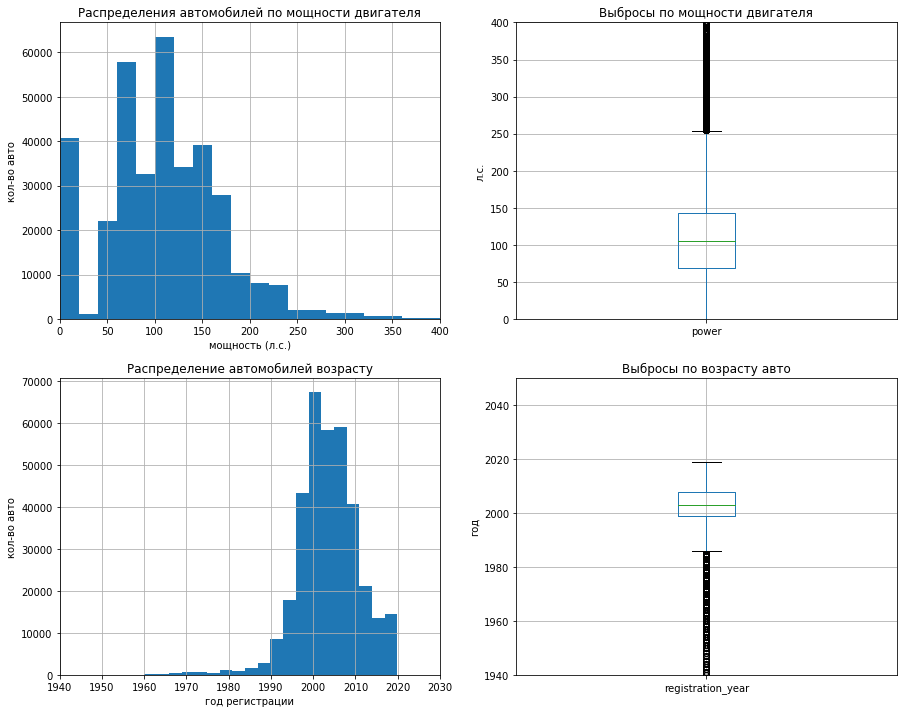

In [8]:
plt.rcParams['figure.figsize'] = [15, 12]
ax = plt.subplot(221)
ax.set_title('Распределения автомобилей по мощности двигателя')
plt.xlim(0, 400)
ax.set_xlabel('мощность (л.с.)')
ax.set_ylabel('кол-во авто')
autos['power'].hist(bins=1000)

ax = plt.subplot(222)
ax.set_title('Выбросы по мощности двигателя')
ax.set_ylabel('л.с.')
plt.ylim(0, 400)
pd.DataFrame(autos['power']).boxplot();

ax = plt.subplot(223)
ax.set_title('Распределение автомобилей возрасту')
plt.xlim(1940, 2030)
ax.set_xlabel('год регистрации')
ax.set_ylabel('кол-во авто')
autos['registration_year'].hist(bins=3000)

ax = plt.subplot(224)
ax.set_title('Выбросы по возрасту авто')
ax.set_ylabel('год')
plt.ylim(1940, 2050)
pd.DataFrame(autos['registration_year']).boxplot();

Удалим выбросы мощности более 250 л.с. и строки с мощностью, равной нулю.  Конечно, существуют автомобили и с бОльшей мощностью двигателя, но их немного и цена на них определяется в индивидуальном порядке.   
Также удаляем выбросы по году регистрации: до 1985 и после 2019. Это или ошибка, которую мы не можем исправить или действительно старые автомобили, цена которых уже не зависит от года выпуска и поределяется индивидуально (бесполезный хлам или дорогой раритет).

In [9]:
autos = autos.query('0<power<=250 and 1985<registration_year<2019')
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302491 entries, 1 to 354368
Data columns (total 10 columns):
price                302491 non-null int64
vehicle_type         280345 non-null object
registration_year    302491 non-null int64
gearbox              296279 non-null object
power                302491 non-null int64
model                290342 non-null object
kilometer            302491 non-null int64
fuel_type            282066 non-null object
brand                302491 non-null object
not_repaired         254734 non-null object
dtypes: int64(4), object(6)
memory usage: 25.4+ MB


Остались пропуски в следующих столбцах:  
vehicle_type - тип кузова может быть разный у одинаковых моделей, меняем на unknown  
gearbox - то же самое, могут быть 2 одинаковые машины с разными коробками, меняем на unknown   
model - никак не восстановить, меняем на unknown   
fuel_type - то же самое, меняем на unknown   
not_repaired - никак не узнать, если  владелец не указал (он и сам может не знать, была ли в ремонте), меняем на unknown 
  
Проведем прямое кодирование техникой OHE для модели линейной регрессии.  
Для остальных моделей проведем порядковое кодирование категориальных признаков.

In [10]:
autos = autos.fillna('unknown')
сategorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

autos_1 = pd.get_dummies(autos, drop_first=True)

encoder = OrdinalEncoder()

autos_ordinal = pd.DataFrame(encoder.fit_transform(autos[сategorical]),
                            columns=сategorical, index=autos.index)
autos[сategorical] = autos_ordinal[сategorical]

# 2. Обучение моделей

Выделим целевой признак и разобъем выборку на тренировочную, валидационную и тестовую. Отдельно для линейной регрессии, отдельно для других моделей.  
Также проведем масштабирование числовых признаков.

In [11]:
warnings.filterwarnings('ignore')

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    autos.drop('price', axis=1), autos.price, test_size=0.4, random_state=12345)

features_train_1, features_valid_test_1, target_train_1, target_valid_test_1 = train_test_split(
    autos_1.drop('price', axis=1), autos_1.price, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

features_valid_1, features_test_1, target_valid_1, target_test_1 = train_test_split(
    features_valid_test_1, target_valid_test_1, test_size=0.5, random_state=12345)

numeric = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
scaler.fit(features_train_1[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train_1[numeric] = scaler.transform(features_train_1[numeric])
features_valid_1[numeric] = scaler.transform(features_valid_1[numeric])
features_test_1[numeric] = scaler.transform(features_test_1[numeric])

Произведем перебор гиперпараметров для модели случайного леса.  
При тестировании диапазон параметров был шире, но и времени было затрачено намного больше.  
ВРЕМЯ РАБОТЫ ЦИКЛОВ 1 МИН.

In [12]:
rmse_min = 5000
for estim in range(23, 26, 1):
    for depth in range(17, 19, 1):
        model = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, prediction)**0.5
        if rmse < rmse_min:
            rmse_min = rmse
            est = estim
            dep = depth
print('Наименьшее значение RMSE', rmse_min, 'при:')
print('max_depth =', dep)
print('n_estimators =', est)

Наименьшее значение RMSE 1617.2847796181568 при:
max_depth = 18
n_estimators = 25


Посмотрим, каково значение метрики для линейной регрессии.

In [13]:
model = LinearRegression()
model.fit(features_train_1, target_train_1)
prediction = model.predict(features_valid_1)
print('RMSE=',  mean_squared_error(target_valid_1, prediction)**0.5)

RMSE= 2372.1231679593716


Теперь произведем перебор гиперпараметров для модели градиентного бустинга.  
При тестировании параметров перебиралось больше, а их диапазон был шире.  
ВРЕМЯ РАБОТЫ ЦИКЛОВ 4 МИН.

In [14]:
rmse_min = 5000
lr = 0.1
while lr <= 0.3:
    for depth in range(17, 21, 1):
        model = lgb.LGBMRegressor(
                     learning_rate = lr, 
                     max_depth = depth,
                     metric = 'rmse',
                     random_state = 12345, 
                     n_estimators = 500
                                        )

        model.fit(features_train, target_train, categorical_feature=сategorical)
        prediction = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, prediction)**0.5
        if rmse < rmse_min:
            rmse_min = rmse
            l_r = lr
            dep = depth
    lr += 0.1
    
print('Наименьшее значение RMSE', rmse_min, 'при:')
print('learning_rate =', l_r)
print('max_depth =', dep)

Наименьшее значение RMSE 1537.250040320259 при:
learning_rate = 0.2
max_depth = 19


# 3. Анализ моделей

Сразу оценим качество константной модели для оценки адекватности остальных.

In [15]:
%%time
prediction = pd.Series(target_train.median(), target_test.index)
print('Для константной модели:')
print('RMSE=',  mean_squared_error(target_test, prediction)**0.5)

Для константной модели:
RMSE= 4756.1200164353895
CPU times: user 9.57 ms, sys: 27 µs, total: 9.6 ms
Wall time: 7.66 ms


Определим модели с подобранными гиперпараметрами.

In [16]:
rf_model = RandomForestRegressor(n_estimators=25, max_depth=18, random_state=12345)

lr_model = LinearRegression()

lgbm_model = lgb.LGBMRegressor(
                     learning_rate = 0.2, 
                     max_depth = 19,
                     metric = 'rmse',
                     random_state = 12345, 
                     n_estimators = 1000
                                        )

Произведем замер скорости обучения и скорости предсказания моделей.  
Сначала для случайного леса.

In [17]:
%%time
rf_model.fit(features_train, target_train)

CPU times: user 11.7 s, sys: 0 ns, total: 11.7 s
Wall time: 11.8 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [18]:
%%time
prediction = rf_model.predict(features_test)
print('RMSE=',  mean_squared_error(target_test, prediction)**0.5)

RMSE= 1588.5015014732476
CPU times: user 489 ms, sys: 0 ns, total: 489 ms
Wall time: 499 ms


Теперь для линейной регрессии.

In [19]:
%%time
lr_model.fit(features_train_1, target_train_1)

CPU times: user 15 s, sys: 3.84 s, total: 18.9 s
Wall time: 18.9 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
%%time
prediction = lr_model.predict(features_test_1)
print('RMSE=',  mean_squared_error(target_test_1, prediction)**0.5)

RMSE= 2372.4197678304076
CPU times: user 116 ms, sys: 101 ms, total: 217 ms
Wall time: 196 ms


И, наконец, для градиентного бустинга. Поставим ограничение на кол-во итераций в зависимости от скорости изменения метрики. Качество модели это уменьшит не сильно, а время обучения может сократиться.

In [21]:
%%time
lgbm_model.fit(features_train, target_train,
               categorical_feature = сategorical, 
               eval_metric= 'rmse', 
               early_stopping_rounds = 10, 
               verbose = 50)

Training until validation scores don't improve for 10 rounds
[50]	valid_0's rmse: 1618.29
[100]	valid_0's rmse: 1585.35
[150]	valid_0's rmse: 1570.58
[200]	valid_0's rmse: 1558.83
[250]	valid_0's rmse: 1550.23
[300]	valid_0's rmse: 1546.49
[350]	valid_0's rmse: 1542.8
[400]	valid_0's rmse: 1538.91
[450]	valid_0's rmse: 1536.23
[500]	valid_0's rmse: 1532.49
[550]	valid_0's rmse: 1530.95
[600]	valid_0's rmse: 1528.84
Early stopping, best iteration is:
[609]	valid_0's rmse: 1528.41
CPU times: user 28.6 s, sys: 269 ms, total: 28.8 s
Wall time: 29.3 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=19,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [22]:
%%time
prediction = lgbm_model.predict(features_test)
print('RMSE =',  mean_squared_error(target_test, prediction)**0.5)

RMSE = 1528.4074482804353
CPU times: user 4.04 s, sys: 1.83 ms, total: 4.04 s
Wall time: 4.09 s


Сведем данные в таблицу.

In [24]:
data = [['-', 11.8, 18.9, 29.3],
        [0.008, 0.5, 0.2, 4.1],
        ['-', 1617, 2372, 1537],
        [4756, 1589, 2372, 1528]
       ]

table = pd.DataFrame(data)
table.columns = ['constant', 'random_forest', 'linear_regression', 'gradient_boosting']
table.index = ['fit_time', 'predict_time', 'RMSE_valid', 'RMSE_test']
table

,constant,random_forest,linear_regression,gradient_boosting
fit_time,-,11.8,18.9,29.3
predict_time,0.008,0.5,0.2,4.1
RMSE_valid,-,1617.0,2372.0,1537.0
RMSE_test,4756,1589.0,2372.0,1528.0


Все модели показывают адекватность относительно константной модели.  
Самое главное для данного сервиса - точность предсказаний, затем скорость предсказания и уже потом скорость обучения.  
По совокупности факторов можно рекомендовать две модели: градиентного бустинга и случайного леса, при этом предпочтение я отдал бы бустингу, т.к точность предсказания в данном случае важнее скорости работы, к тому же предсказывать одну конкретную цену модель будет быстрее.